# Cleaning and Exploring Weather Data from Kaggle User tobycrabtree
<a id='header_cell'></a>
This is a notebook to clean and conduct exploratory data analysis on the weather [data](https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data?select=spreadspoke_scores.csv) provided by kaggle user tobycrabtree and [NFLWeather.com](http://www.nflweather.com/). 

In this notebook, I intend to:  
- standardize all column names according to our project architecture with all special characters removed
- find all null values and address them appropriately
- fill in missing data as needed
- Narrow the data to the 2019 and 2020 regular seasons

At the end of this notebook, I'll write the cleaned tobycrabtree data to ```../../fixtures/cleaned_data/weather_data.csv``` and the cleaned days_since_last_game_df data to ```../../fixtures/cleaned_data/days_since_last_game.csv```

### Table of Contents:
<a id='toc_cell'></a>
- [Cleaning and Exploring Weather Data from Kaggle User tobycrabtree](#header_cell)
- [Table of Contents](#toc_cell)
- [Import Packages and Read in Data](#import_and_read_cell)
- [Cleaning the Data](#cleaning_the_data_header_cell)
    - [Understanding the Data](#understanding_cell)
    - [Answering Initial Questions](#answering_cell)
    - [Filtering the Dataset and Transforming Column Datatypes and Values](#filtering_dataset_cell)
    - [Finding and Addressing Null Values](#finding_addressing_null_values_cell)
    - [Addressing Null Weather Values](#addressing_null_weather_values_cell)
    - [Cleaning New Weather Data](#cleaning_new_weather_data_cell)
- [Exploring the Data](#eda_header_cell)

## Import Packages and Read in Data
<a id='import_and_read_cell'></a>
We'll start by importing pandas to manipulate and store the data, then matplotlib's pyplot module, seaborn, and missingno to visualize the data. We'll also set up Jupyter magic to visualize pyplot visualizations inline. Finally, we'll read the data into a dataframe.

In [1]:
# manipulation, data retrieval, and storage packages
import pandas as pd
import os
import re
import requests
import ssl
import json
import datetime as dt
from datetime import datetime
from datetime import date
import numpy as np

# visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import urllib.request
from bs4 import BeautifulSoup

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('../../fixtures/raw_data/spreadspoke_scores.csv')

## Cleaning the Data
<a id='cleaning_the_data_header_cell'></a>

### Understanding the Data
<a id='understanding_cell'></a>

In [4]:
df.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,9/2/1966,1966,1,False,Miami Dolphins,14.0,23.0,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71,NaN
1,9/3/1966,1966,1,False,Houston Oilers,45.0,7.0,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70,NaN
2,9/4/1966,1966,1,False,San Diego Chargers,27.0,7.0,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82,NaN
3,9/9/1966,1966,2,False,Miami Dolphins,14.0,19.0,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78,NaN
4,9/10/1966,1966,1,False,Green Bay Packers,24.0,3.0,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62,NaN


### Initial observations, to-dos, and questions from looking at the first few rows
#### Questions I have about the data:
- How many rows and columns are in the dataset?
- What are the data types contained in the columns?
- Are there any games not played at the home team's stadium?
- The weather_temperature and weather_wind_mph columns are floats, but weather_humidity column is an integer. Is this distinction reflected in the data?
- The first few rows of the weather_detail column are NaN. What is contained in the weather_detail column?

#### Things to do to the data:
- This dataset has the following columns, which I can use to produce columns for the database:
    - schedule_week and schedule_year columns -> week_id column
    - schedule_date -> days_since_last_game and week_day columns
    - team_home and team_away -> location column, team_name, and opponent columns within the opponents_table
- team_home and team_away columns need to be translated into the abbreviations that are the column names in the opponents_table

### Answering Initial Questions
<a id='answering_cell'></a>

In [5]:
# How many rows and columns are in the dataset?

"There are {} rows and {} columns in this dataset".format(df.shape[0], df.shape[1])

'There are 12947 rows and 17 columns in this dataset'

In [6]:
# What are the data types contained in the columns?

df.dtypes

schedule_date           object
schedule_season          int64
schedule_week           object
schedule_playoff          bool
team_home               object
score_home             float64
score_away             float64
team_away               object
team_favorite_id        object
spread_favorite        float64
over_under_line         object
stadium                 object
stadium_neutral           bool
weather_temperature    float64
weather_wind_mph       float64
weather_humidity        object
weather_detail          object
dtype: object

Are there any games not played at the home team's stadium? To answer this, I'll see how many unique combinations of the team_home and stadium columns

In [7]:
stadium_count = "There are {} unique home team/stadium combinations in this dataset".format(
    df.groupby(['team_home','stadium']).size().reset_index().rename(columns={0:'count'}).shape[0])

print(stadium_count)

There are 177 unique home team/stadium combinations in this dataset


177 unique combinations? For 32 teams?   

My NFL knowledge doesn't precede 2020, but I'm sure there's been a few teams added, a few stadium names changed, a few teams with name changes.   

This doesn't answer whether or not all games are played at the home team's stadium, or in what circumstances in which they are played in a neutral stadium!   

The stadium_neutral column might help, so I'll check it for True values and look at only at 2019 and later.   

I'll filter out non-playoff games since that's what we'll use for our model

In [8]:
df.loc[(df['stadium_neutral'] == True)
    & (df['schedule_playoff'] == False)
    & (df['schedule_season'] >= 2019)]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
12483,10/6/2019,2019,5,False,Oakland Raiders,24.0,21.0,Chicago Bears,CHI,-6.5,39.5,Tottenham Hotspur Stadium,True,NaN,NaN,NaN,NaN
12501,10/13/2019,2019,6,False,Tampa Bay Buccaneers,26.0,37.0,Carolina Panthers,CAR,-2.0,47.5,Tottenham Hotspur Stadium,True,NaN,NaN,NaN,NaN
12526,10/27/2019,2019,8,False,Los Angeles Rams,24.0,10.0,Cincinnati Bengals,LAR,-12.0,48.5,Wembley Stadium,True,NaN,NaN,NaN,NaN
12537,11/3/2019,2019,9,False,Jacksonville Jaguars,3.0,26.0,Houston Texans,JAX,-1.0,46,Wembley Stadium,True,NaN,NaN,NaN,NaN
12572,11/18/2019,2019,11,False,Los Angeles Chargers,17.0,24.0,Kansas City Chiefs,KC,-5.5,52.5,Estadio Azteca,True,NaN,NaN,NaN,NaN
12868,12/7/2020,2020,13,False,San Francisco 49ers,24.0,34.0,Buffalo Bills,SF,-1.5,48,State Farm Stadium,True,NaN,NaN,NaN,NaN


6 non-playoff games between 2019 and 2020 were played in neutral locations, and (after a wikipedia search) 5 of these games were played in England or Mexico all in the 2019 season. The only other one was played in Arizona by the 49ers and Bills in 2020, which Google told me was due to COVID-19 restrictions preventing the 49ers from playing in their home county.   

When creating the team_home column, I'll set both teams to 0 for these 6 games since it's not in the typical home stadium for home team fans to come out for the team.   

This, however, has me thinking about COVID-19 restrictions on home teams in 2020. Did being the home team matter in 2020 as it did in 2019? The simple answer is no: fans were allowed in stadiums without restrictions in 2019 but were heavily restricted in 2020.   

*But does being the home team matter at all, regardless of fan attendance restrictions?*   

I think it does. While professional football fields don't deviate from one another anywhere near how much MLB stadiums deviate from one another, a player would be most comfortable at his home stadium due to spotting the ball among the seats and knowing where the sun will hit his eyes and when, among other things.   

I think we should add another column where we either describe the number of fans in attendance or specify whether or not fan attendance restrictions were in place.

To-do: fan restrictions column

In [9]:
# The weather_temperature and weather_wind_mph columns are floats, but weather_humidity column is an integer.
# Is this distinction reflected in the data?

cols = ['weather_temperature','weather_wind_mph']

for x in cols:
    # reveal values in these two columns that are not evenly divisible by zero
    [print(n) for n in df[x] if n % 1 != 0.0 == True]

weather_temperature and weather_wind_mph do not have values that do not end with .0, so we'll convert these columns to integers   

To-do: convert weather_temperature and weather_wind_mph to integer

In [10]:
# The first few rows of the weather_detail column are NaN. What is contained in the weather_detail column?

print(df['weather_detail'].unique())

[nan 'DOME' 'Rain' 'Rain | Fog' 'Fog' 'Snow' 'DOME (Open Roof)'
 'Snow | Fog' 'Snow | Freezing Rain']


Seems like a helpful column to contribute to our precipitation column in the database. Let's see what the unique values are in the 2019 and 2020 season.

In [11]:
df.loc[
    (df['weather_detail'].notnull())
    & (df['schedule_season'] >= 2019)
    & (df['schedule_playoff'] == False)]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
12412,9/8/2019,2019,1,False,Arizona Cardinals,27.0,27.0,Detroit Lions,DET,-3.0,45.5,University of Phoenix Stadium,False,72.0,0.0,NaN,DOME
12415,9/8/2019,2019,1,False,Dallas Cowboys,35.0,17.0,New York Giants,DAL,-7.0,44,AT&T Stadium,False,72.0,0.0,NaN,DOME
12419,9/8/2019,2019,1,False,Minnesota Vikings,28.0,12.0,Atlanta Falcons,MIN,-3.5,47,U.S. Bank Stadium,False,72.0,0.0,NaN,DOME
12425,9/9/2019,2019,1,False,New Orleans Saints,30.0,28.0,Houston Texans,NO,-6.5,51.5,Mercedes-Benz Superdome,False,72.0,0.0,NaN,DOME
12428,9/15/2019,2019,2,False,Atlanta Falcons,24.0,20.0,Philadelphia Eagles,PHI,-1.0,53,Mercedes-Benz Stadium,False,72.0,0.0,NaN,DOME
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12907,12/27/2020,2020,16,False,Dallas Cowboys,37.0,17.0,Philadelphia Eagles,PHI,-3.0,50.5,AT&T Stadium,False,72.0,0.0,NaN,DOME
12909,12/27/2020,2020,16,False,Houston Texans,31.0,37.0,Cincinnati Bengals,HOU,-7.5,46,NRG Stadium,False,72.0,0.0,NaN,DOME
12924,1/3/2021,2020,17,False,Detroit Lions,35.0,37.0,Minnesota Vikings,MIN,-3.0,53.5,Ford Field,False,72.0,0.0,NaN,DOME
12925,1/3/2021,2020,17,False,Houston Texans,38.0,41.0,Tennessee Titans,TEN,-7.0,55.5,NRG Stadium,False,72.0,0.0,NaN,DOME


I'm seeing a pattern: 128 rows with all displayed being 'DOME' weather_detail values? I'll see what values appear if non-'DOME' values are selected

In [12]:
df.loc[
    (df['weather_detail'] != 'DOME')
    & (df['schedule_season'] >= 2019)
    & (df['schedule_playoff'] == False)]

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
12411,9/5/2019,2019,1,False,Chicago Bears,3.0,10.0,Green Bay Packers,CHI,-3.0,46.5,Soldier Field,False,NaN,NaN,NaN,NaN
12413,9/8/2019,2019,1,False,Carolina Panthers,27.0,30.0,Los Angeles Rams,LAR,-2.0,49.5,Bank of America Stadium,False,NaN,NaN,NaN,NaN
12414,9/8/2019,2019,1,False,Cleveland Browns,13.0,43.0,Tennessee Titans,CLE,-5.5,44,FirstEnergy Stadium,False,NaN,NaN,NaN,NaN
12416,9/8/2019,2019,1,False,Jacksonville Jaguars,26.0,40.0,Kansas City Chiefs,KC,-3.5,49,TIAA Bank Field,False,NaN,NaN,NaN,NaN
12417,9/8/2019,2019,1,False,Los Angeles Chargers,30.0,24.0,Indianapolis Colts,LAC,-6.0,44.5,StubHub Center,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12929,1/3/2021,2020,17,False,New England Patriots,28.0,14.0,New York Jets,NE,-3.0,41,Gillette Stadium,False,NaN,NaN,NaN,NaN
12930,1/3/2021,2020,17,False,New York Giants,23.0,19.0,Dallas Cowboys,DAL,-1.5,43.5,MetLife Stadium,False,NaN,NaN,NaN,NaN
12931,1/3/2021,2020,17,False,Philadelphia Eagles,14.0,20.0,Washington Football Team,WAS,-6.5,43.5,Lincoln Financial Field,False,NaN,NaN,NaN,NaN
12932,1/3/2021,2020,17,False,San Francisco 49ers,23.0,26.0,Seattle Seahawks,SEA,-7.0,45,Levi's Stadium,False,NaN,NaN,NaN,NaN


### Filtering the Dataset and Transforming Column Datatypes and Values
<a id='filtering_dataset_cell'></a>
Before progressing with further data exploration and cleaning, I'm going to start by filtering the dataset to post-2019 data and non-playoff data. I'm also going to drop the team_favorite_id, spread_favorite, and over_under_line columns as these aren't applicable for this project. I'll also transform score_home and score_away from float to integer and schedule_date to datetime.

In [13]:
df = df[(df['schedule_season'] >= 2019) & (df['schedule_playoff'] == False)].drop(
    ['team_favorite_id','spread_favorite','over_under_line','schedule_playoff'], axis = 1).astype(
    {'score_home': int, 'score_away': int, 'schedule_week' : str, 'schedule_season' : str}
)

df['schedule_date'] = pd.to_datetime(df['schedule_date'], infer_datetime_format=True)

print("There are {} rows and {} columns in this dataset".format(df.shape[0], df.shape[1]))

There are 512 rows and 13 columns in this dataset


Next, I'll convert the team names in the team_home and team_away columns into the abbreviations that are the column names in the opponents_table within the database schema using a dictionary.

In [14]:
team_dict = {
    "Arizona Cardinals":"ARZ",
    "Atlanta Falcons":"ATL",
    "Baltimore Ravens":"BLT",
    "Buffalo Bills":"BUF",
    "Carolina Panthers":"CAR",
    "Chicago Bears":"CHI",
    "Cincinnati Bengals":"CIN",
    "Cleveland Browns":"CLV",
    "Dallas Cowboys":"DAL",
    "Denver Broncos":"DEN",
    "Detroit Lions":"DET",
    "Green Bay Packers":"GB",
    "Houston Texans":"HST",
    "Indianapolis Colts":"IND",
    "Jacksonville Jaguars":"JAX",
    "Kansas City Chiefs":"KC",
    "Oakland Raiders":"LV",
    "Las Vegas Raiders":"LV",
    "Los Angeles Chargers":"LAC",
    "Los Angeles Rams":"LAR",
    "Miami Dolphins":"MIA",
    "Minnesota Vikings":"MIN",
    "New England Patriots":"NE",
    "New Orleans Saints":"NO",
    "New York Giants":"NYG",
    "New York Jets":"NYJ",
    "Philadelphia Eagles":"PHI",
    "Pittsburgh Steelers":"PIT",
    "San Francisco 49ers":"SF",
    "Seattle Seahawks":"SEA",
    "Tampa Bay Buccaneers":"TB",
    "Tennessee Titans":"TEN",
    "Washington Redskins":"WAS",
    "Washington Football Team":"WAS"
}

In [15]:
df['team_away_short'] = df['team_away'].map(team_dict)
df['team_home_short'] = df['team_home'].map(team_dict)

Next, I'll create the week_id column using the schedule_season and schedule_week columns to add to the database. I'll keep the schedule_season and schedule_week columns in case I need to order by week (since the week_id column is a string and not sortable) or filter by year

In [16]:
df['week_id'] = df['schedule_season'] + "_" + df['schedule_week']

Now I'll make the week_day column by iterating through the schedule_date column using the weekday() method from the datetime package

In [17]:
df['week_day'] = [x.weekday() for x in df['schedule_date']]

In [18]:
team_names = df['team_home'].unique()

Next, I'll engineer the ```days_since_last_game``` column identified as needed in our architecture, which I'll make using ```schedule_date, team_away, team_home``` and ```schedule_week```

In [229]:
cols = ['team_home_short', 'team_away_short']

teams = df['team_home_short'].unique()

# Create new columns for all teams as long as they appear in either home or away
for n in teams:
    df[n] = (df[cols] == n).any(axis = "columns")
    
# Create new columns for all teams where we record days since they last played
for n in teams:
    df[n+'_days_since_last_game'] = df[df[n] == True].groupby(n)['schedule_date'].diff().apply(lambda x: x.days)


days_since_last_game_df = pd.DataFrame()

team_name = []
week_id = []
days_since_last_game = []

for n in teams:
    for x in range(0,df.shape[0]):
        if df.iloc[x][n] == True:
            team_name.append(n)
            week_id.append(df['week_id'].iloc[x])
            days_since_last_game.append(df[n+'_days_since_last_game'].iloc[x])
        else:
            pass
            
days_since_last_game_df['team_name'] = team_name
days_since_last_game_df['week_id'] = week_id
days_since_last_game_df['days_since_last_game'] = days_since_last_game

days_since_last_game_df.head()

,team_name,week_id,days_since_last_game
0,CHI,2019_1,NaN
1,CHI,2019_2,10.0
2,CHI,2019_3,8.0
3,CHI,2019_4,6.0
4,CHI,2019_5,7.0


In [232]:
days_since_last_game_df['days_since_last_game'] = days_since_last_game_df['days_since_last_game'].fillna(365)

In [233]:
days_since_last_game_df['days_since_last_game'] = [int(x) for x in days_since_last_game_df['days_since_last_game']]

In [234]:
days_since_last_game_df

,team_name,week_id,days_since_last_game
0,CHI,2019_1,365
1,CHI,2019_2,10
2,CHI,2019_3,8
3,CHI,2019_4,6
4,CHI,2019_5,7
...,...,...,...
1019,SF,2020_13,8
1020,SF,2020_14,6
1021,SF,2020_15,7
1022,SF,2020_16,6


Now that I have satsifed the need for these columns for our database, I'll make a new dataframe and drop all rows made during this process

In [235]:
days_since_last_game_df.to_csv('../../fixtures/cleaned_data/days_since_last_game.csv')

In [237]:
df = df.drop([
 'SEA',
 'CHI',
 'ARZ',
 'CAR',
 'CLV',
 'DAL',
 'JAX',
 'LAC',
 'MIA',
 'MIN',
 'NE',
 'NYJ',
 'PHI',
 'TB',
 'NO',
 'LV',
 'ATL',
 'BLT',
 'CIN',
 'DEN',
 'DET',
 'GB',
 'HST',
 'LAR',
 'NYG',
 'PIT',
 'TEN',
 'WAS',
 'BUF',
 'IND',
 'KC',
 'SF',
 'CHI_days_since_last_game',
 'ARZ_days_since_last_game',
 'CAR_days_since_last_game',
 'CLV_days_since_last_game',
 'DAL_days_since_last_game',
 'JAX_days_since_last_game',
 'LAC_days_since_last_game',
 'MIA_days_since_last_game',
 'MIN_days_since_last_game',
 'NE_days_since_last_game',
 'NYJ_days_since_last_game',
 'PHI_days_since_last_game',
 'SEA_days_since_last_game',
 'TB_days_since_last_game',
 'NO_days_since_last_game',
 'LV_days_since_last_game',
 'ATL_days_since_last_game',
 'BLT_days_since_last_game',
 'CIN_days_since_last_game',
 'DEN_days_since_last_game',
 'DET_days_since_last_game',
 'GB_days_since_last_game',
 'HST_days_since_last_game',
 'LAR_days_since_last_game',
 'NYG_days_since_last_game',
 'PIT_days_since_last_game',
 'TEN_days_since_last_game',
 'WAS_days_since_last_game',
 'BUF_days_since_last_game',
 'IND_days_since_last_game',
 'KC_days_since_last_game',
 'SF_days_since_last_game'
], axis = 1)

### Finding and Addressing Null Values
<a id='finding_addressing_null_values_cell'></a>

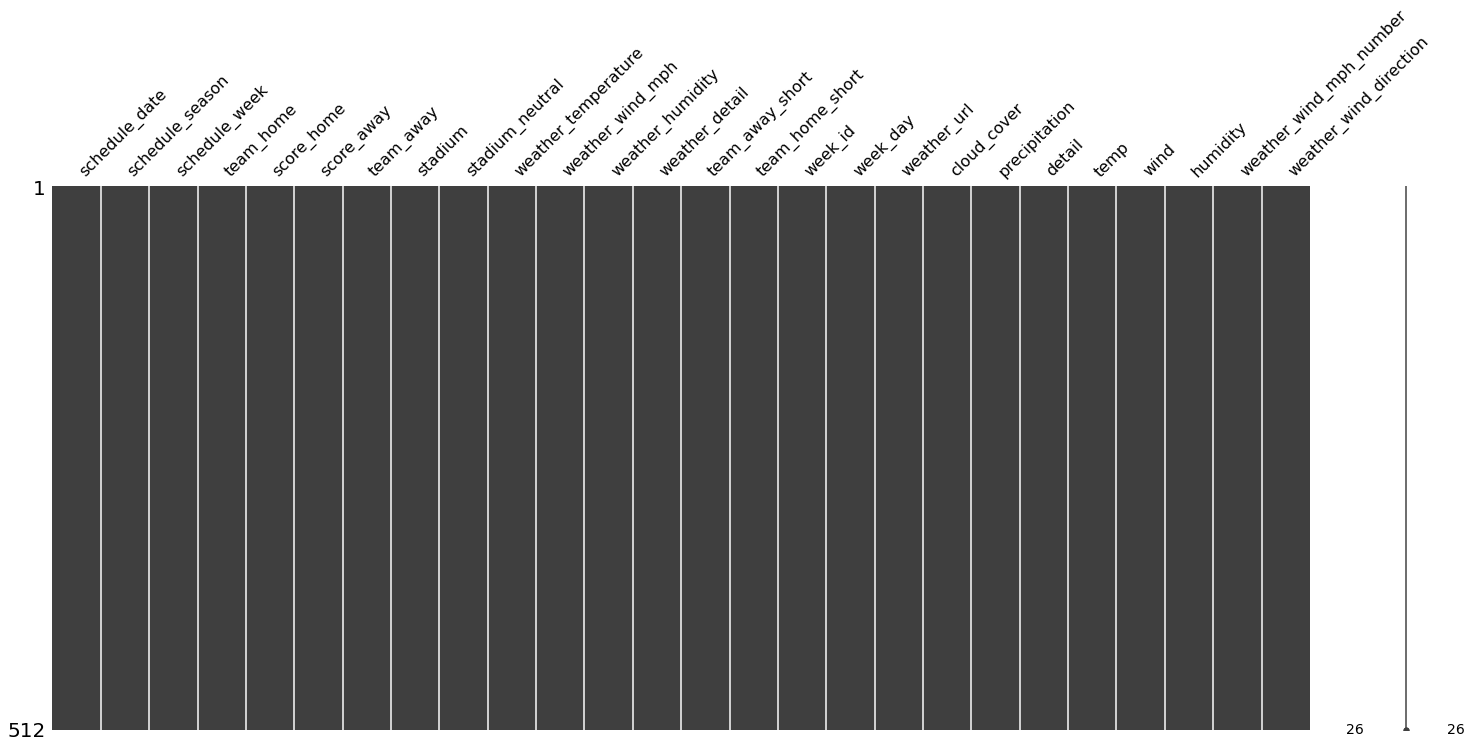

In [238]:
msno.matrix(df) # show missing values with a missing number matrix
plt.show() # hide image metadata

The far right vertical bar shows us that the columns with null values range between 13 and 16 nulls. The temperature, wind, and weather detail columns are spotty in terms of nulls, and humidity looks to be blank altogether. We'll need to fill in these gaps 

### Addressing Null Weather Values
<a id='addressing_null_weather_values_cell'></a>
To fill in the weather column gaps and seek other weather factors for use in our data, I will be using data from [NFLWeather.com](http://www.nflweather.com/), which does not have an API but does have a sensible URL structure from which I can pull weather data.   

I'll 

I'll start by making a new column that holds the last word of each team name and converting it to all lower case letters, then I'll create another column for the last part of the URL and finally go through all values in this URL column to pull our weather data.   

Finally, I'll take my new weather data, use the fillna() method to full in my null values and then get rid of the extra columns created during this process.

In [23]:
f = lambda x: x['team_away'].split()[-1].lower()
f1 = lambda x: x['team_home'].split()[-1].lower()

In [24]:
df['team_away_last'] = df.apply(f, axis =1)
df['team_home_last'] = df.apply(f1, axis = 1)

In [25]:
df['weather_url'] = df['schedule_season'] + '/week-' + df['schedule_week'] + '/' + df['team_away_last'] + '-at-' + df['team_home_last']

In [26]:
detail = []
temp = []
wind = []
humidity = []
cloud_cover = []
precipitation = []

for n in df['weather_url']:
    
    try:
    
        source = urllib.request.urlopen('http://www.nflweather.com/en/game/' + n).read()
        soup = BeautifulSoup(source, 'html.parser')
    
        detail.append(soup.find_all('p')[3].text.strip())
        temp.append(soup.find_all('p')[4].text.strip())
        wind.append(soup.find_all('p')[6].text.strip())
        humidity.append(soup.find_all('p')[7].text.strip())
        cloud_cover.append(soup.find_all('p')[11].text.strip())
        precipitation.append(soup.find_all('p')[12].text.strip())
        
    except Exception:
        
        try:
            
            source = urllib.request.urlopen('http://www.nflweather.com/en/game/' + (n.replace('team','redskins'))).read()
            soup = BeautifulSoup(source, 'html.parser')

            detail.append(soup.find_all('p')[3].text.strip())
            temp.append(soup.find_all('p')[4].text.strip())
            wind.append(soup.find_all('p')[6].text.strip())
            humidity.append(soup.find_all('p')[7].text.strip())
            cloud_cover.append(soup.find_all('p')[11].text.strip())
            precipitation.append(soup.find_all('p')[12].text.strip())
        
        except Exception:
            
            try:
            
                source = urllib.request.urlopen('http://www.nflweather.com/en/game/' + (n.replace('team','football%20team'))).read()
                soup = BeautifulSoup(source, 'html.parser')

                detail.append(soup.find_all('p')[3].text.strip())
                temp.append(soup.find_all('p')[4].text.strip())
                wind.append(soup.find_all('p')[6].text.strip())
                humidity.append(soup.find_all('p')[7].text.strip())
                cloud_cover.append(soup.find_all('p')[11].text.strip())
                precipitation.append(soup.find_all('p')[12].text.strip())
                
            except Exception:
            
                try:

                    source = urllib.request.urlopen('http://www.nflweather.com/en/game/' + (n.replace('team','washington'))).read()
                    soup = BeautifulSoup(source, 'html.parser')

                    detail.append(soup.find_all('p')[3].text.strip())
                    temp.append(soup.find_all('p')[4].text.strip())
                    wind.append(soup.find_all('p')[6].text.strip())
                    humidity.append(soup.find_all('p')[7].text.strip())
                    cloud_cover.append(soup.find_all('p')[11].text.strip())
                    precipitation.append(soup.find_all('p')[12].text.strip())
                
                except Exception:
                    print(f'Error with url http://www.nflweather.com/en/game/{n}')

In [50]:
df['detail'] = detail
df['temp'] = temp
df['wind'] = wind
df['humidity'] = humidity
df['cloud_cover'] = cloud_cover
df['precipitation'] = precipitation

In [53]:
df['weather_temperature'].fillna(df['temp'], inplace = True)
df['weather_humidity'].fillna(df['humidity'], inplace = True)
df['weather_detail'].fillna(df['detail'], inplace = True)
df['weather_wind_mph'].fillna(df['wind'], inplace = True)

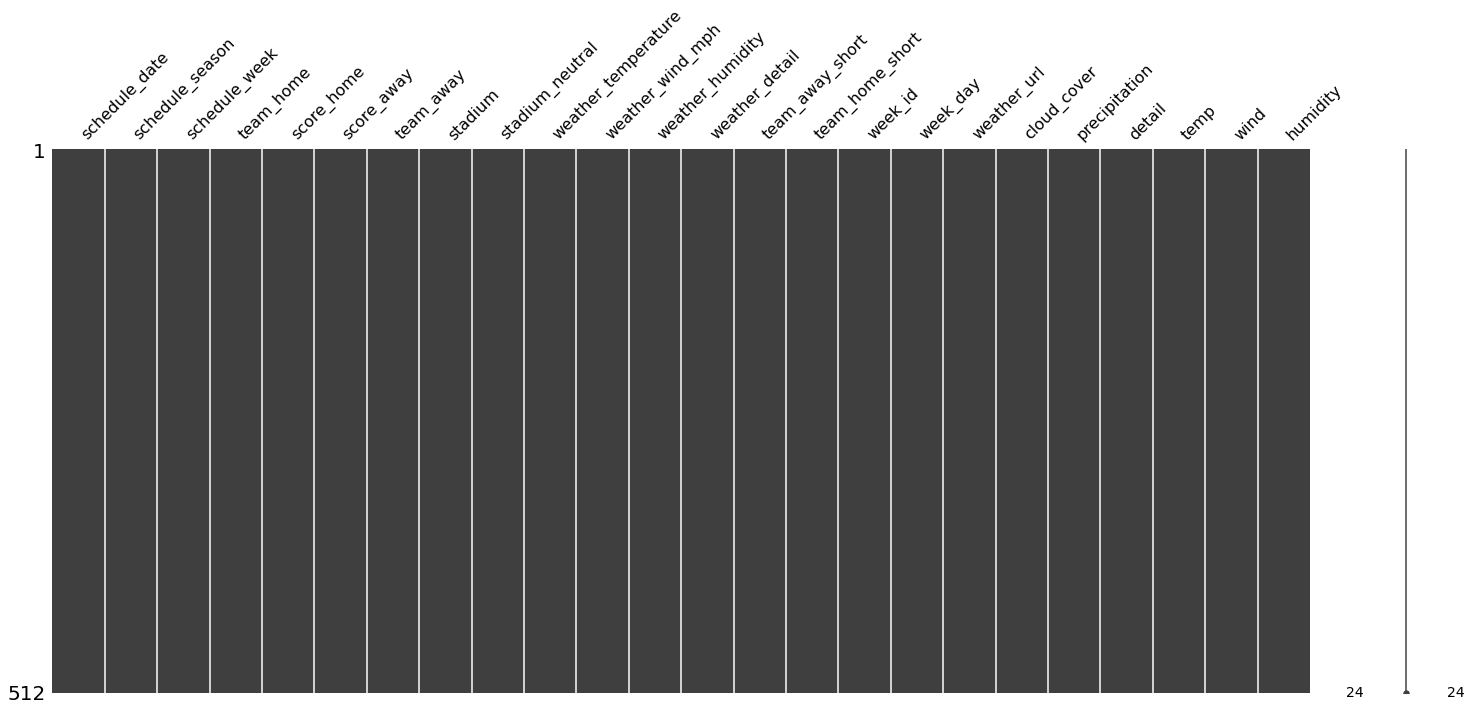

In [46]:
msno.matrix(df) # show missing values with a missing number matrix
plt.show() # hide image metadata

In [51]:
df = df.drop([
    'team_away_last',
    'team_home_last',
    'humidity',
    'wind',
    'temp',
    'detail'
], axis = 1)

KeyError: "['team_away_last' 'team_home_last'] not found in axis"

### Cleaning New Weather Data
<a id='cleaning_new_weather_data_cell'></a>
Now I'll clean and standardize the new weather data!   
I'll make all applicable weather data into either integers or floats and correct any other issues

In [137]:
df['weather_temperature'].unique()

array([65, 72, 85, 69, 93, 73, 89, 64, 74, 79, 66, 91, 86, 81, 82, 88, 84,
       90, 80, 78, 92, 71, 62, 60, 57, 70, 75, 55, 76, 58, 67, 68, 87, 54,
       61, 83, 51, 42, 59, 53, 49, 56, 52, 48, 50, 63, 45, 35, 47, 46, 40,
       33, 37, 41, 44, 43, 38, 30, 34, 32, 13, 25, 31, 39, 95, 77, 14, 27,
       36])

In [135]:
df['weather_temperature'] = df['weather_temperature'].replace({'Temperature: ':'','f.':''}, regex = True)
df['weather_temperature'] = [int(n) for n in df['weather_temperature']]

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [58]:
df['weather_temperature'].unique()[:10]

array([65, 72, 85, 69, 93, 73, 89, 64, 74, 79])

In [59]:
df['weather_humidity'].unique()[:10]

array([0.66, 0.32, 0.48, 0.64, 0.28, 0.67, 0.63, 0.93, 0.5 , 0.39])

In [60]:
df['weather_humidity'] = df['weather_humidity'].replace({'Humidity: ':'0.','%':''}, regex = True)
df['weather_humidity'] = [float(n) for n in df['weather_humidity']]

TypeError: Cannot compare types 'ndarray(dtype=float64)' and 'str'

In [61]:
df['weather_humidity'].unique()[:10]

array([0.66, 0.32, 0.48, 0.64, 0.28, 0.67, 0.63, 0.93, 0.5 , 0.39])

In [62]:
df['weather_wind_mph'].unique()[:10]

array(['Wind: 7mi East - SouthEast', 'Wind: 6mi West - SouthWest',
       'Wind: 3mi East', 'Wind: 6mi NorthEast',
       'Wind: 9mi South - SouthEast', 'Wind: 3mi SouthWest',
       'Wind: 6mi South - SouthWest', 'Wind: 7mi SouthEast',
       'Wind: 3mi East - NorthEast', 'Wind: 3mi NorthWest'], dtype=object)

In [63]:
df['weather_wind_mph'] = df['weather_wind_mph'].replace('Wind: ','', regex = True)

In [69]:
df['weather_wind_mph'].unique()[:10]

array(['7mi East - SouthEast', '6mi West - SouthWest', '3mi East',
       '6mi NorthEast', '9mi South - SouthEast', '3mi SouthWest',
       '6mi South - SouthWest', '7mi SouthEast', '3mi East - NorthEast',
       '3mi NorthWest'], dtype=object)

In [106]:
df['weather_wind_mph'].iloc[0].split()[1:]

['East', '-', 'SouthEast']

In [108]:
f2 = lambda x: int(x['weather_wind_mph'].split()[0][:-2])
f3 = lambda x: ''.join([s.strip() for s in x['weather_wind_mph'].split(' ', 1) [1:]])

In [109]:
df['weather_wind_mph_number'] = df.apply(f2, axis =1)
df['weather_wind_direction'] = df.apply(f3, axis =1)

In [72]:
df['weather_wind_mph_number'].unique()

array([ 7,  6,  3,  9,  4,  5, 10,  1,  2, 11,  8, 12,  0, 16, 14, 18, 15,
       13, 17, 26, 21, 24, 23])

In [111]:
df['weather_wind_direction'].unique()

array(['East - SouthEast', 'West - SouthWest', 'East', 'NorthEast',
       'South - SouthEast', 'SouthWest', 'South - SouthWest', 'SouthEast',
       'East - NorthEast', 'NorthWest', 'West - NorthWest', 'West',
       'South', 'North - NorthWest', 'North', 'North - NorthEast'],
      dtype=object)

# Exploring the Data
<a id='eda_header_cell'></a>

[Click here to go back to the top](#header_cell)

In [244]:
plt.rcParams["figure.figsize"] = (25,15)

In [277]:
def scatterMaker(x_column, y_column, color_column):
    fig = plt.scatter(x_column, y_column, c = color_column)

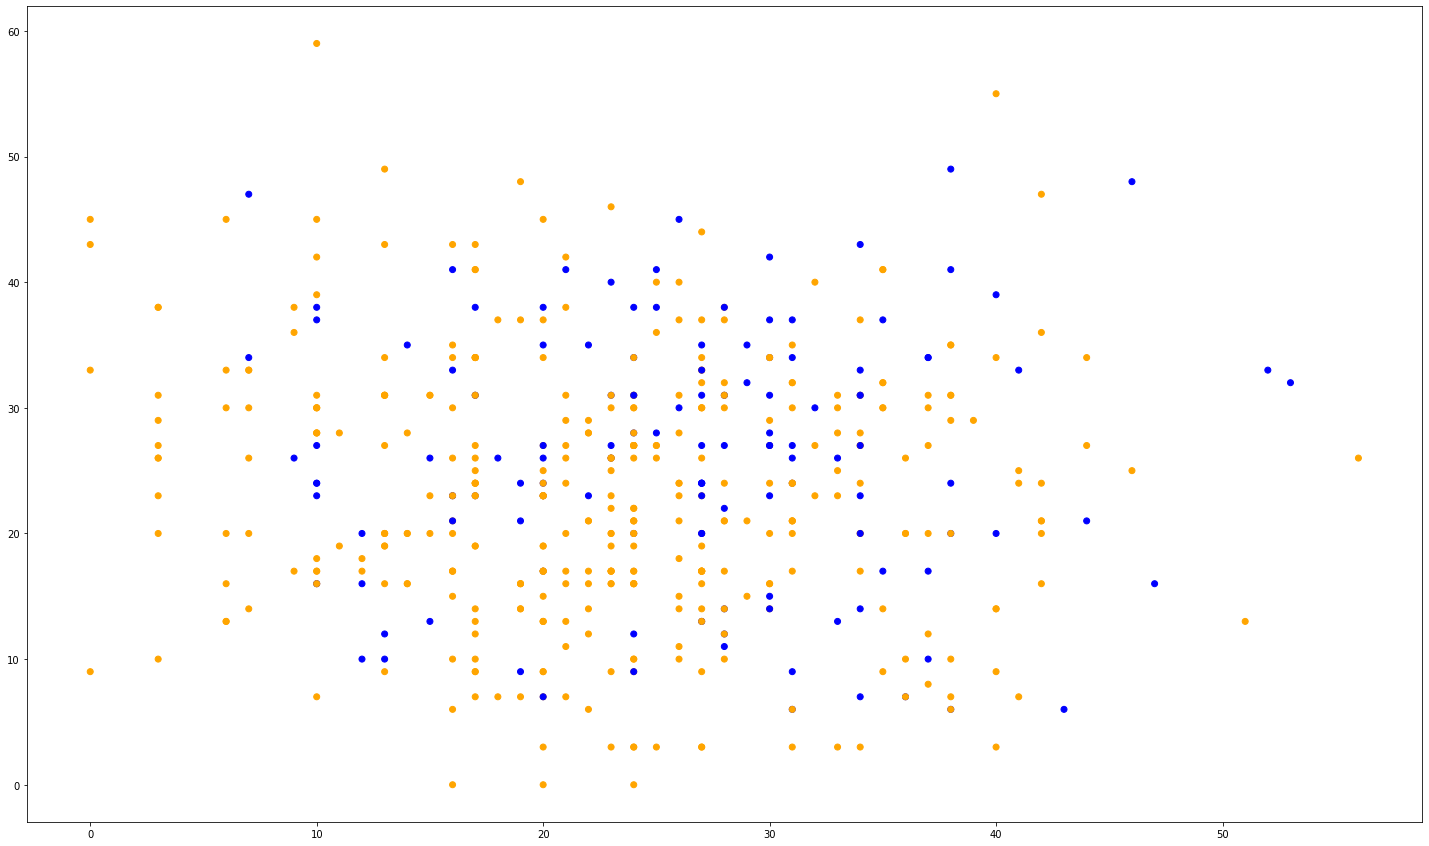

In [278]:
scatterMaker(df['score_home'], df['score_away'], df['dome_or_not'])

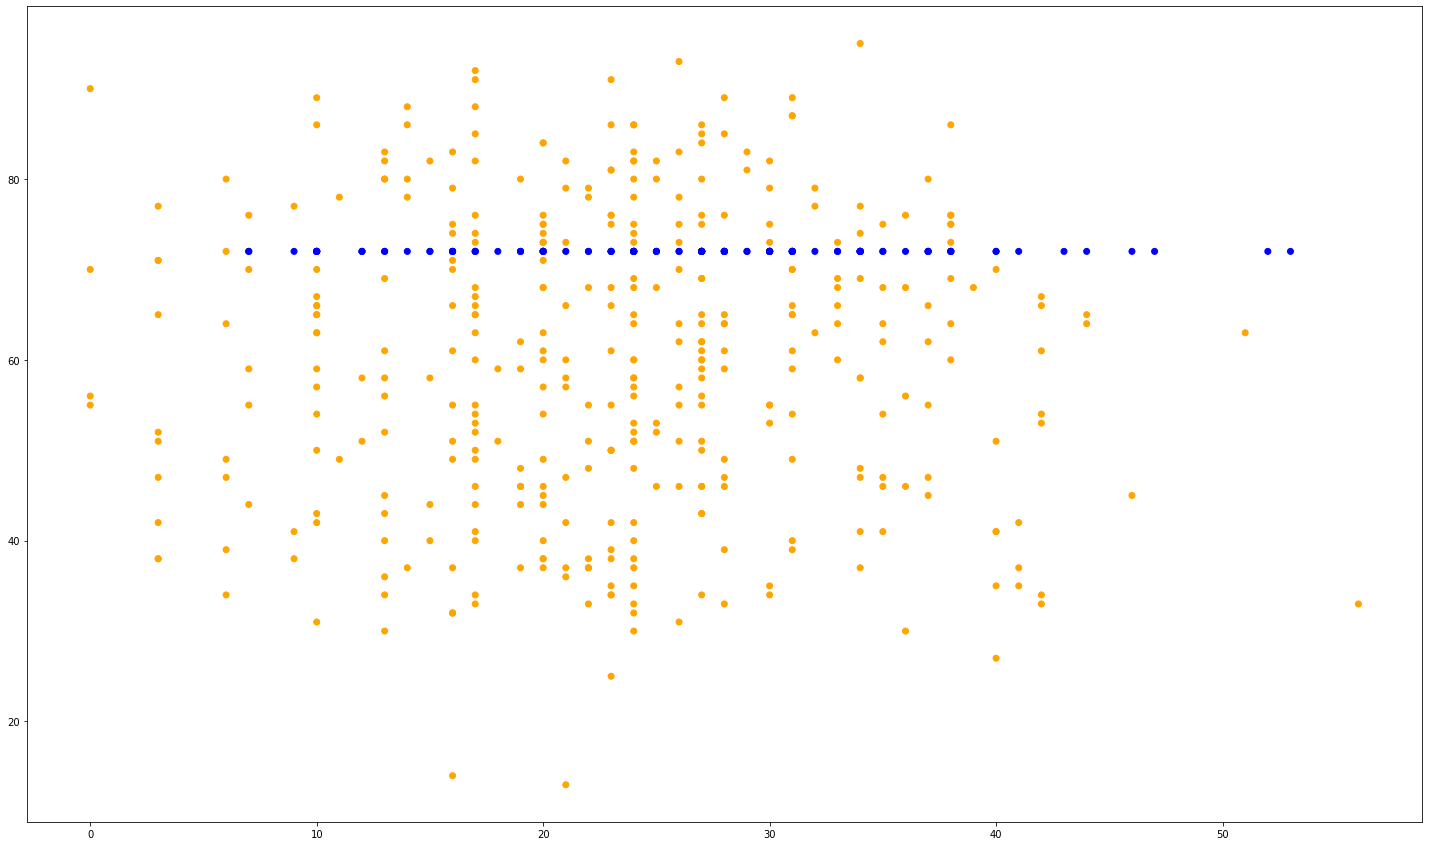

In [280]:
scatterMaker(df['score_home'], df['weather_temperature'], df['dome_or_not'])